In [1]:
!pip install arabic-reshaper python-bidi

import arabic_reshaper
from bidi.algorithm import get_display
ARABIC_SUPPORT = True

In [2]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
import joblib
import warnings

In [3]:
print("=" * 60)
print("ARABIC TEXT AUTHORSHIP ATTRIBUTION")
print("Enhanced Traditional Machine Learning Approach")
print("=" * 60)

# Author name mappings from Arabic to English
author_arabic_to_english = {
    'أحمد أمين': 'Ahmed Amin',
    'أحمد تيمور باشا': 'Ahmed Taymour Pasha', 
    'أحمد شوقي': 'Ahmed Shawqi',
    'أمين الريحاني': 'Ameen Rihani',
    'ثروت أباظة': 'Tharwat Abaza',
    'جبران خليل جبران': 'Gibran Khalil Gibran',
    'جُرجي زيدان': 'Jurji Zaydan',
    'حسن حنفي': 'Hassan Hanafi',
    'روبرت بار': 'Robert Barr',
    'سلامة موسى': 'Salama Moussa',
    'طه حسين': 'Taha Hussein',
    'عباس محمود العقاد': 'Abbas M. Al-Aqqad',
    'عبد الغفار مكاوي': 'Abdel Ghaffar Makawi',
    'غوستاف لوبون': 'Gustave Le Bon',
    'فؤاد زكريا': 'Fouad Zakaria',
    'كامل كيلاني': 'Kamel Kilani',
    'محمد حسين هيكل': 'Mohamed H. Heikal',
    'نجيب محفوظ': 'Naguib Mahfouz',
    'نوال السعداوي': 'Nawal El Saadawi',
    'ويليام شيكسبير': 'William Shakespeare',
    'يوسف إدريس': 'Yusuf Idris',
}

ARABIC TEXT AUTHORSHIP ATTRIBUTION
Enhanced Traditional Machine Learning Approach


In [4]:
def fix_arabic_text(text):
    """Fix Arabic text for proper display in matplotlib"""
    if ARABIC_SUPPORT and isinstance(text, str):
        reshaped_text = arabic_reshaper.reshape(text)
        bidi_text = get_display(reshaped_text)
        return bidi_text
    return text

def get_english_name(arabic_name):
    """Get English name for Arabic author name"""
    if pd.isna(arabic_name):
        return "Unknown Author"
    
    clean_arabic = arabic_name.strip()
    
    if clean_arabic in author_arabic_to_english:
        return author_arabic_to_english[clean_arabic]
    
    print(f"Author not found in mapping: {clean_arabic}")
    return clean_arabic

def create_reverse_mapping():
    """Create English to Arabic mapping"""
    return {english: arabic for arabic, english in author_arabic_to_english.items()}

def verify_dataset_authors(train_data, val_data):
    """Verify which authors from dataset are in our mapping"""
    all_authors = set(train_data['author'].unique()) | set(val_data['author'].unique())
    
    mapped_authors = []
    unmapped_authors = []
    
    for author in all_authors:
        if author in author_arabic_to_english:
            mapped_authors.append(author)
        else:
            unmapped_authors.append(author)
    
    print(f"Mapped authors: {len(mapped_authors)}")
    print(f"Unmapped authors: {len(unmapped_authors)}")
    
    if unmapped_authors:
        print("\nUnmapped authors:")
        for author in unmapped_authors[:10]:
            print(f"  - {author}")
        if len(unmapped_authors) > 10:
            print(f"  ... and {len(unmapped_authors) - 10} more")
    
    return mapped_authors, unmapped_authors

def add_english_names_to_data(train_data, val_data):
    """Add English name columns to the datasets"""
    train_data = train_data.copy()
    val_data = val_data.copy()
    
    train_data['author_english'] = train_data['author'].apply(get_english_name)
    val_data['author_english'] = val_data['author'].apply(get_english_name)
    
    return train_data, val_data

def create_enhanced_visualizations(train_data, val_data):
    """Create visualizations with English names"""
    train_enhanced, val_enhanced = add_english_names_to_data(train_data, val_data)
    
    mapped_authors, unmapped_authors = verify_dataset_authors(train_data, val_data)
    
    fig, ((ax1, ax2), (ax3, ax_empty)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # Training data distribution with English names
    author_counts_train = train_enhanced['author_english'].value_counts()
    top_15_train = author_counts_train.head(15)
    
    bars1 = ax1.bar(range(len(top_15_train)), top_15_train.values, 
                   color='steelblue', edgecolor='navy', alpha=0.8)
    ax1.set_title('Top 15 Authors Distribution - Training Data\n(English Names)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Author', fontsize=12)
    ax1.set_ylabel('Number of Texts', fontsize=12)
    ax1.set_xticks(range(len(top_15_train)))
    ax1.set_xticklabels(top_15_train.index, rotation=45, ha='right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(top_15_train)*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Validation data distribution
    author_counts_val = val_enhanced['author_english'].value_counts()
    top_15_val = author_counts_val.head(15)
    
    bars2 = ax2.bar(range(len(top_15_val)), top_15_val.values, 
                   color='crimson', edgecolor='darkred', alpha=0.8)
    ax2.set_title('Top 15 Authors Distribution - Validation Data\n(English Names)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Author', fontsize=12)
    ax2.set_ylabel('Number of Texts', fontsize=12)
    ax2.set_xticks(range(len(top_15_val)))
    ax2.set_xticklabels(top_15_val.index, rotation=45, ha='right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(top_15_val)*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Side-by-side comparison for common authors
    common_authors = set(train_enhanced['author_english']) & set(val_enhanced['author_english'])
    common_list = sorted(list(common_authors))[:21]
    
    train_common = [author_counts_train.get(author, 0) for author in common_list]
    val_common = [author_counts_val.get(author, 0) for author in common_list]
    
    x = np.arange(len(common_list))
    width = 0.35
    
    ax3.bar(x - width/2, train_common, width, label='Training', 
            color='lightblue', edgecolor='darkblue', alpha=0.8)
    ax3.bar(x + width/2, val_common, width, label='Validation', 
            color='lightcoral', edgecolor='darkred', alpha=0.8)
    
    ax3.set_title('Common Authors: Training vs Validation\n(English Names)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax3.set_xlabel('Author', fontsize=12)
    ax3.set_ylabel('Number of Texts', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(common_list, rotation=45, ha='right', fontsize=10)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    ax_empty.axis('off')
    plt.tight_layout()
    plt.show()
    
    return train_enhanced, val_enhanced

def create_confusion_matrix_english(y_true, y_pred, top_n=10):
    """Create confusion matrix with English author names"""
    author_counts = pd.Series(y_true).value_counts()
    top_authors_arabic = author_counts.head(top_n).index
    top_authors_english = [get_english_name(author) for author in top_authors_arabic]
    
    mask = pd.Series(y_true).isin(top_authors_arabic)
    y_true_filtered = pd.Series(y_true)[mask]
    y_pred_filtered = pd.Series(y_pred)[mask]
    
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_authors_arabic)
    
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral_r',
                xticklabels=top_authors_english,
                yticklabels=top_authors_english,
                cbar_kws={'shrink': 0.8})
    
    plt.title(f'Confusion Matrix - Top {top_n} Authors (English Names)', 
              fontsize=20, fontweight='bold', pad=30)
    plt.xlabel('Predicted Author', fontsize=16)
    plt.ylabel('True Author', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

def save_translation_mapping():
    """Save the translation mapping to CSV"""
    mapping_df = pd.DataFrame([
        {'Arabic_Name': arabic, 'English_Name': english}
        for arabic, english in author_arabic_to_english.items()
    ]).sort_values('English_Name')
    
    mapping_df.to_csv('author_translations.csv', index=False, encoding='utf-8-sig')
    print("Author translation mapping saved to 'author_translations.csv'")
    
    return mapping_df

print("Direct author mapping functions ready!")
print(f"Current mapping contains {len(author_arabic_to_english)} authors")


Direct author mapping functions ready!
Current mapping contains 21 authors


# DATA LOADING

In [ ]:
train_data = pd.read_excel("Data/AuthorshipClassficiationTrain.xlsx")
val_data = pd.read_excel("Data/AuthorshipClassficiationVal.xlsx")

print(f"Data loaded successfully!")
print(f"Training data: {len(train_data)} samples, {len(train_data.columns)} columns")
print(f"Validation data: {len(val_data)} samples, {len(val_data.columns)} columns")
print(f"Columns: {list(train_data.columns)}")

Data loaded successfully!
Training data: 35122 samples, 3 columns
Validation data: 4157 samples, 3 columns
Columns: ['id', 'text_in_author_style', 'author']


Mapped authors: 21
Unmapped authors: 0

Top 10 authors in training data (English names):
 1. Hassan Hanafi: 3744
 2. Ahmed Amin: 2897
 3. Jurji Zaydan: 2768
 4. Robert Barr: 2682
 5. Mohamed H. Heikal: 2627
 6. Taha Hussein: 2376
 7. Abbas M. Al-Aqqad: 1829
 8. Fouad Zakaria: 1773
 9. Naguib Mahfouz: 1634
10. Ameen Rihani: 1567
Mapped authors: 21
Unmapped authors: 0


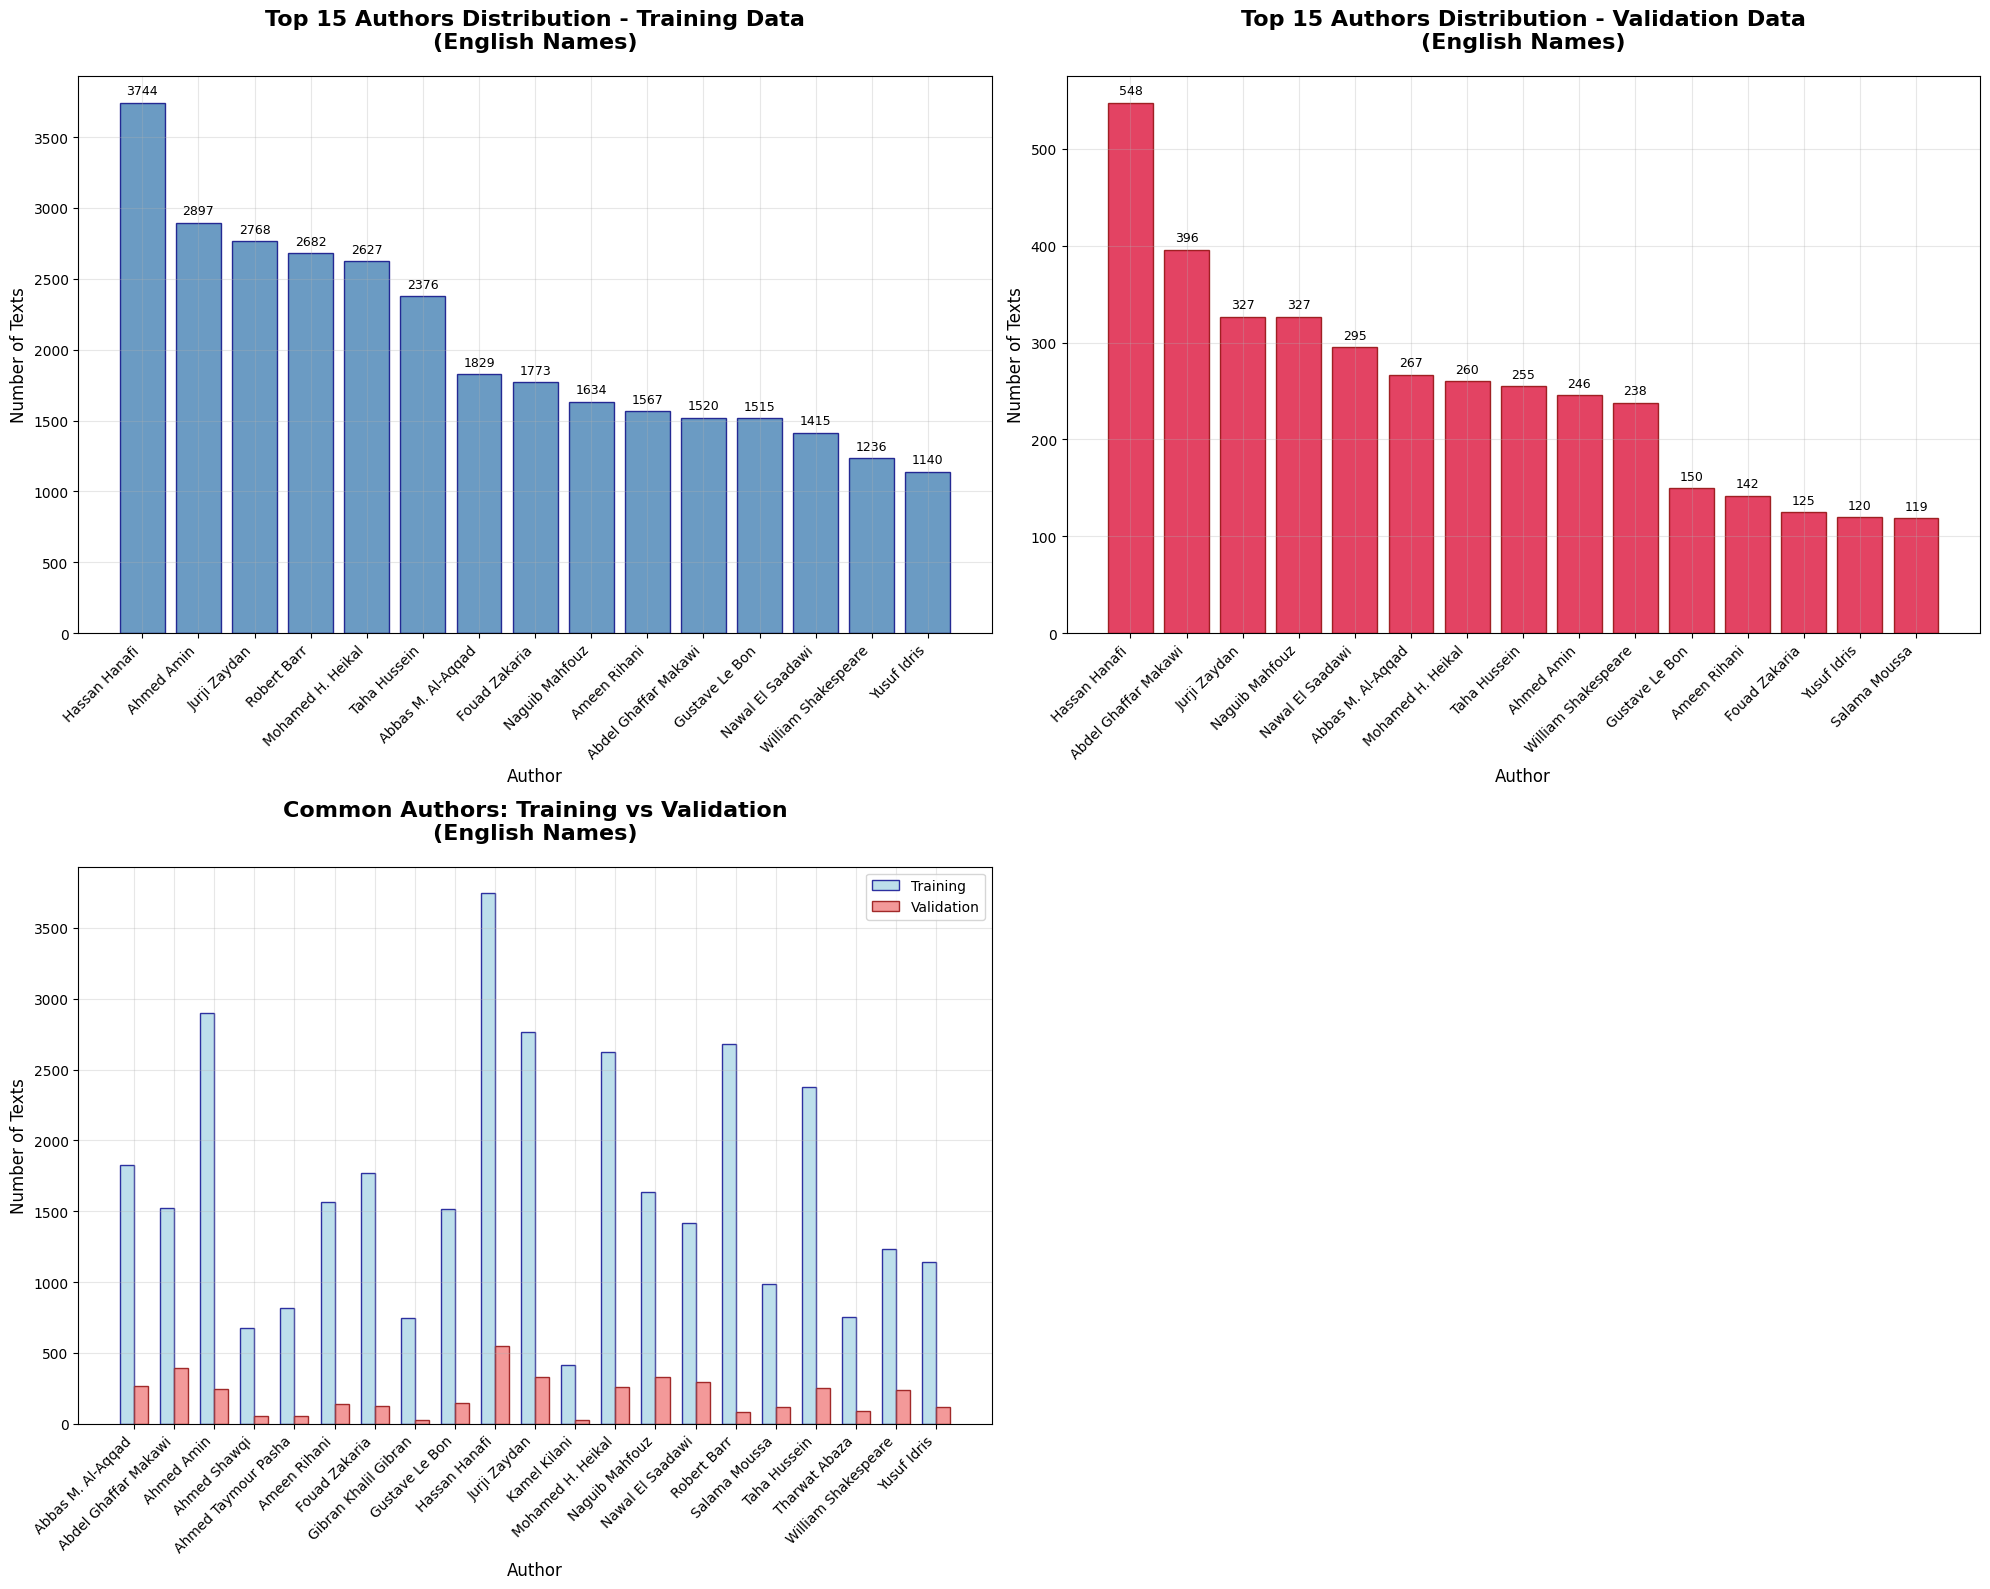

Author translation mapping saved to 'author_translations.csv'


,Arabic_Name,English_Name
11,عباس محمود العقاد,Abbas M. Al-Aqqad
12,عبد الغفار مكاوي,Abdel Ghaffar Makawi
0,أحمد أمين,Ahmed Amin
2,أحمد شوقي,Ahmed Shawqi
1,أحمد تيمور باشا,Ahmed Taymour Pasha
3,أمين الريحاني,Ameen Rihani
14,فؤاد زكريا,Fouad Zakaria
5,جبران خليل جبران,Gibran Khalil Gibran
13,غوستاف لوبون,Gustave Le Bon
7,حسن حنفي,Hassan Hanafi


In [6]:
# Check existing names and add English names
mapped_authors, unmapped_authors = verify_dataset_authors(train_data, val_data)

if unmapped_authors:
    print(f"\nFound {len(unmapped_authors)} unmapped authors")

train_data_enhanced, val_data_enhanced = add_english_names_to_data(train_data, val_data)

author_counts_train = train_data_enhanced['author_english'].value_counts()
print(f"\nTop 10 authors in training data (English names):")
for i, (author, count) in enumerate(author_counts_train.head(10).items()):
    print(f"{i+1:2d}. {author}: {count}")

train_data, val_data = create_enhanced_visualizations(train_data, val_data)
save_translation_mapping()


# TEXT PREPROCESSING

In [7]:
def clean_arabic_text(text):
    """Clean Arabic text by removing numbers, non-Arabic characters, and extra spaces"""
    if pd.isna(text):
        return ""
    
    # Remove English numbers
    text = re.sub(r'[0-9]+', '', text)
    
    # Keep only Arabic characters and spaces
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF\s]', '', text)
    
    # Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\n+', ' ', text)
    
    return text

In [8]:
# Apply text cleaning
train_data['cleaned_text'] = train_data['text_in_author_style'].apply(clean_arabic_text)
val_data['cleaned_text'] = val_data['text_in_author_style'].apply(clean_arabic_text)

# Filter out very short texts
train_data = train_data[train_data['cleaned_text'].str.len() > 10]
val_data = val_data[val_data['cleaned_text'].str.len() > 10]

print(f"After preprocessing:")
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

After preprocessing:
Training samples: 35122
Validation samples: 4157


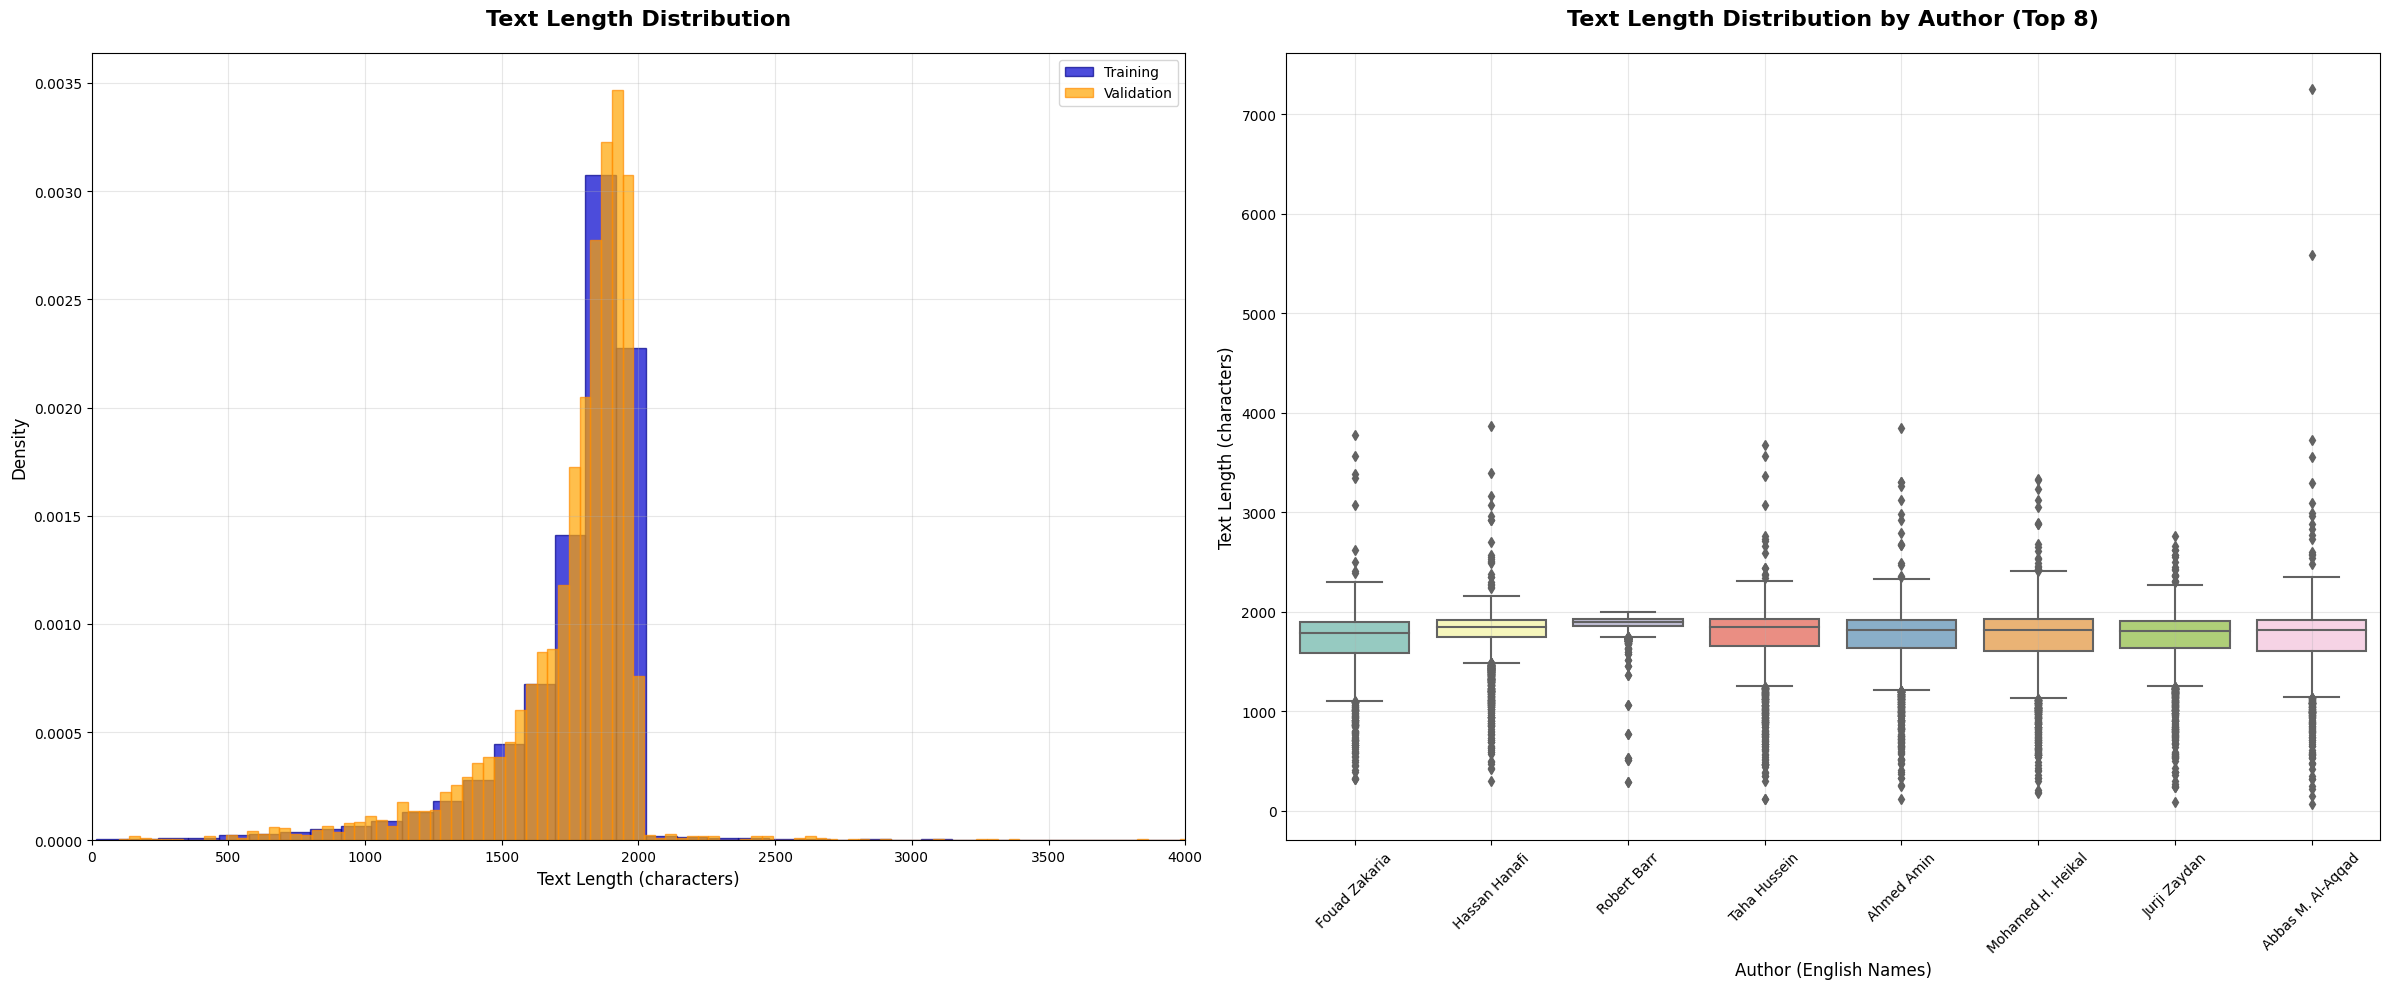


Text Length Statistics:
Training - Mean: 1773.49, Median: 1851.00
Validation - Mean: 1755.40, Median: 1836.00


In [9]:
# Text length statistics visualization
text_lengths_train = train_data['cleaned_text'].str.len()
text_lengths_val = val_data['cleaned_text'].str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

ax1.hist(text_lengths_train, bins=100, alpha=0.7, label='Training', 
         color='mediumblue', edgecolor='darkblue', density=True)
ax1.hist(text_lengths_val, bins=100, alpha=0.7, label='Validation', 
         color='orange', edgecolor='darkorange', density=True)
ax1.set_xlim(0, 4000)
ax1.set_title('Text Length Distribution', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Text Length (characters)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

top_8_authors_english = train_data['author_english'].value_counts().head(8).index
train_top_8 = train_data[train_data['author_english'].isin(top_8_authors_english)].copy()
train_top_8['text_length'] = train_top_8['cleaned_text'].str.len()

sns.boxplot(data=train_top_8, x='author_english', y='text_length', ax=ax2, palette='Set3')
ax2.set_title('Text Length Distribution by Author (Top 8)', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Author (English Names)', fontsize=12)
ax2.set_ylabel('Text Length (characters)', fontsize=12)
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nText Length Statistics:")
print(f"Training - Mean: {text_lengths_train.mean():.2f}, Median: {text_lengths_train.median():.2f}")
print(f"Validation - Mean: {text_lengths_val.mean():.2f}, Median: {text_lengths_val.median():.2f}")


# FEATURE EXTRACTION

In [10]:
train_authors = set(train_data['author'].unique())
val_authors = set(val_data['author'].unique())
common_authors = train_authors.intersection(val_authors)
print(f"Common authors between training and validation: {len(common_authors)}")

train_filtered = train_data[train_data['author'].isin(common_authors)]
val_filtered = val_data[val_data['author'].isin(common_authors)]

X_train_full = train_filtered['cleaned_text']
y_train_full = train_filtered['author']
X_val = val_filtered['cleaned_text']
y_val = val_filtered['author']

print("Creating TF-IDF vectorizers...")
tfidf_words = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.9,
    sublinear_tf=True
)

tfidf_chars = TfidfVectorizer(
    analyzer='char',
    ngram_range=(2, 4),
    max_features=5000,
    min_df=2,
    max_df=0.8
)

Common authors between training and validation: 21
Creating TF-IDF vectorizers...


In [11]:
X_train_words = tfidf_words.fit_transform(X_train_full)
X_val_words = tfidf_words.transform(X_val)

X_train_chars = tfidf_chars.fit_transform(X_train_full)
X_val_chars = tfidf_chars.transform(X_val)

X_train_combined = hstack([X_train_words, X_train_chars])
X_val_combined = hstack([X_val_words, X_val_chars])

print(f"Combined feature matrix shape:")
print(f"Training: {X_train_combined.shape}")
print(f"Validation: {X_val_combined.shape}")

Combined feature matrix shape:
Training: (35122, 20000)
Validation: (4157, 20000)


# MODEL TRAINING AND EVALUATION

In [12]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM (SGD)': SGDClassifier(loss='hinge', random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=20),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20),
}

In [13]:
results = {}
predictions = {}

print("\nTraining and evaluating models...")
print("=" * 60)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    model.fit(X_train_combined, y_train_full)
    
    y_pred = model.predict(X_val_combined)
    predictions[name] = y_pred
    
    accuracy = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')
    f1_weighted = f1_score(y_val, y_pred, average='weighted')
    
    cv_scores = cross_val_score(model, X_train_combined, y_train_full, 
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                               scoring='f1_macro', n_jobs=-1)
    
    results[name] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'model': model
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")



Training and evaluating models...

Training Logistic Regression...
Accuracy: 0.9040
F1-Score (Macro): 0.8246
F1-Score (Weighted): 0.8988
CV F1-Score: 0.9622 (+/- 0.0030)

Training Naive Bayes...
Accuracy: 0.7922
F1-Score (Macro): 0.6809
F1-Score (Weighted): 0.7775
CV F1-Score: 0.8396 (+/- 0.0075)

Training Linear SVM (SGD)...
Accuracy: 0.9322
F1-Score (Macro): 0.8752
F1-Score (Weighted): 0.9295
CV F1-Score: 0.9767 (+/- 0.0019)

Training Decision Tree...
Accuracy: 0.3223
F1-Score (Macro): 0.2435
F1-Score (Weighted): 0.3188
CV F1-Score: 0.4569 (+/- 0.0092)

Training Random Forest...
Accuracy: 0.5932
F1-Score (Macro): 0.4628
F1-Score (Weighted): 0.5594
CV F1-Score: 0.7275 (+/- 0.0098)


# MODEL PERFORMANCE VISUALIZATION

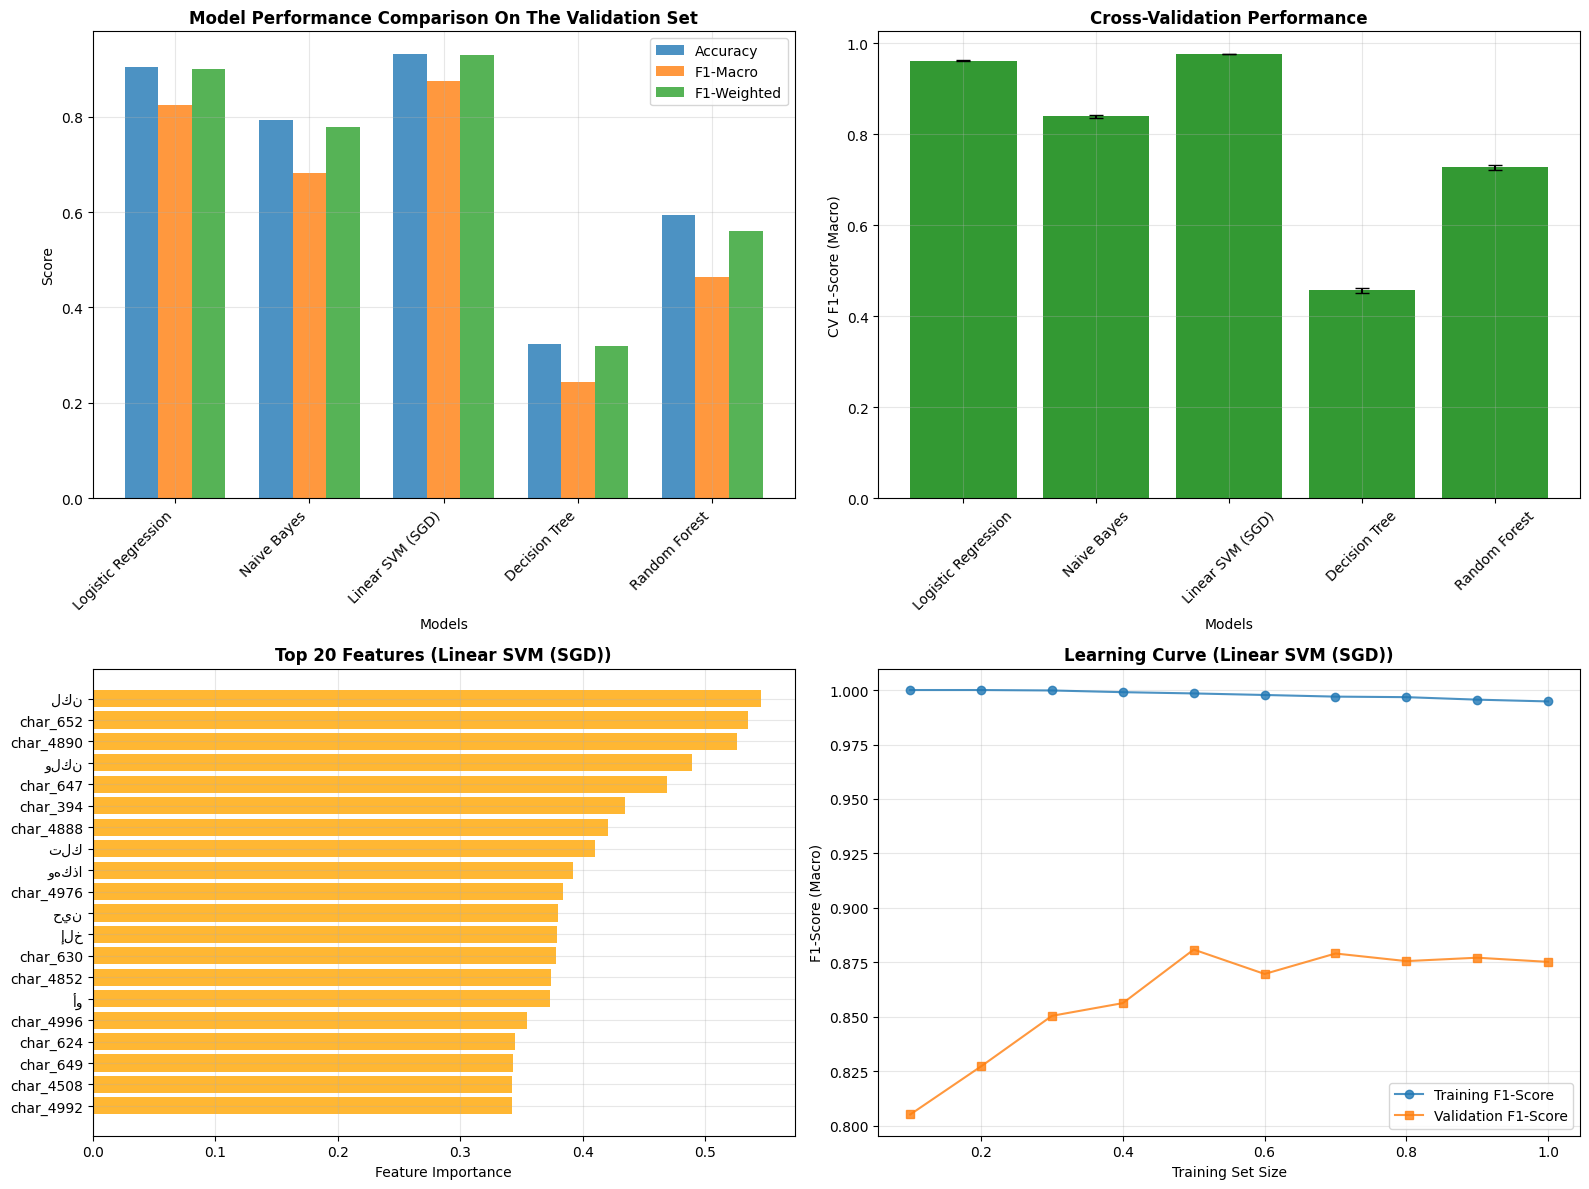

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
f1_macros = [results[name]['f1_macro'] for name in model_names]
f1_weighteds = [results[name]['f1_weighted'] for name in model_names]

x = np.arange(len(model_names))
width = 0.25

ax1.bar(x - width, accuracies, width, label='Accuracy', alpha=0.8)
ax1.bar(x, f1_macros, width, label='F1-Macro', alpha=0.8)
ax1.bar(x + width, f1_weighteds, width, label='F1-Weighted', alpha=0.8)
ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison On The Validation Set', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

cv_models = [name for name in model_names if results[name]['cv_mean'] is not None]
cv_means = [results[name]['cv_mean'] for name in cv_models]
cv_stds = [results[name]['cv_std'] for name in cv_models]

ax2.bar(cv_models, cv_means, yerr=cv_stds, capsize=5, alpha=0.8, color='green')
ax2.set_xlabel('Models')
ax2.set_ylabel('CV F1-Score (Macro)')
ax2.set_title('Cross-Validation Performance', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

best_model_name = max(results.keys(), key=lambda x: results[x]['f1_macro'])
best_model = results[best_model_name]['model']

if hasattr(best_model, 'coef_'):
    feature_names = (list(tfidf_words.get_feature_names_out()) + 
                    [f"char_{i}" for i in range(tfidf_chars.max_features)])
    
    if len(best_model.coef_.shape) > 1:
        importance = np.abs(best_model.coef_).mean(axis=0)
    else:
        importance = np.abs(best_model.coef_)
    
    top_indices = np.argsort(importance)[-20:]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = importance[top_indices]
    
    ax3.barh(range(len(top_features)), top_importance, alpha=0.8, color='orange')
    ax3.set_yticks(range(len(top_features)))
    ax3.set_yticklabels(top_features)
    ax3.set_xlabel('Feature Importance')
    ax3.set_title(f'Top 20 Features ({best_model_name})', fontweight='bold')
    ax3.grid(True, alpha=0.3)

train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
train_scores = []
val_scores = []

for size in train_sizes:
    if size < 1.0:
        X_sample, _, y_sample, _ = train_test_split(
            X_train_combined, y_train_full, train_size=size, 
            stratify=y_train_full, random_state=42
        )
    else:
        X_sample, y_sample = X_train_combined, y_train_full
    
    temp_model = type(best_model)(**best_model.get_params())
    temp_model.fit(X_sample, y_sample)
    
    train_pred = temp_model.predict(X_sample)
    val_pred = temp_model.predict(X_val_combined)
    
    train_scores.append(f1_score(y_sample, train_pred, average='macro'))
    val_scores.append(f1_score(y_val, val_pred, average='macro'))

ax4.plot(train_sizes, train_scores, 'o-', label='Training F1-Score', alpha=0.8)
ax4.plot(train_sizes, val_scores, 's-', label='Validation F1-Score', alpha=0.8)
ax4.set_xlabel('Training Set Size')
ax4.set_ylabel('F1-Score (Macro)')
ax4.set_title(f'Learning Curve ({best_model_name})', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# CONFUSION MATRIX ANALYSIS

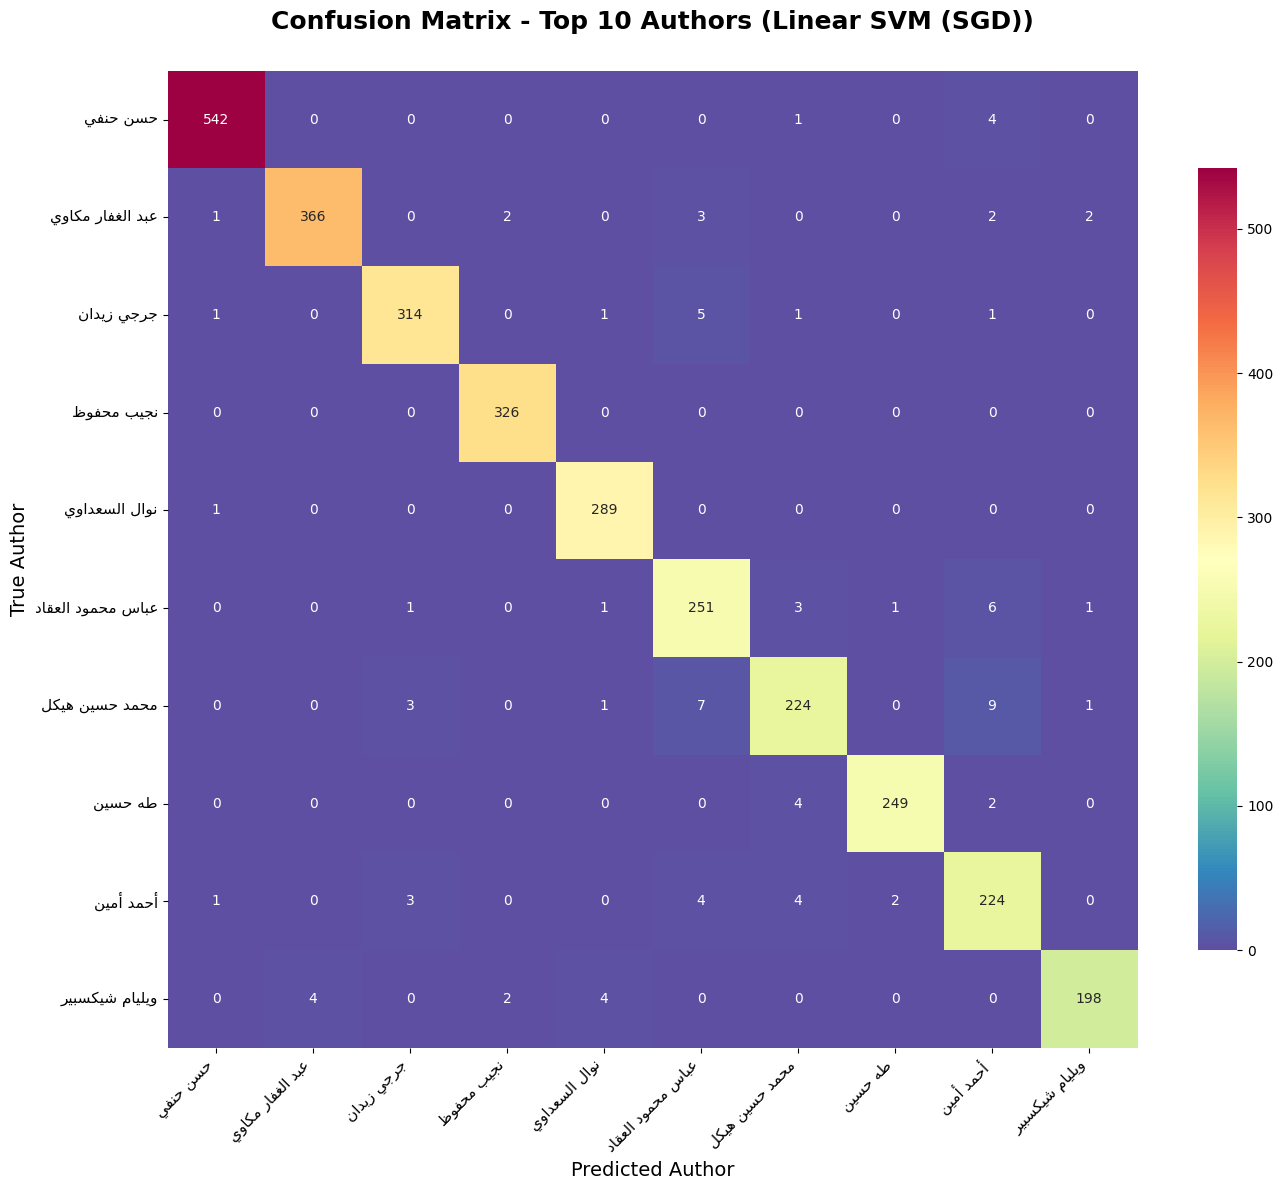

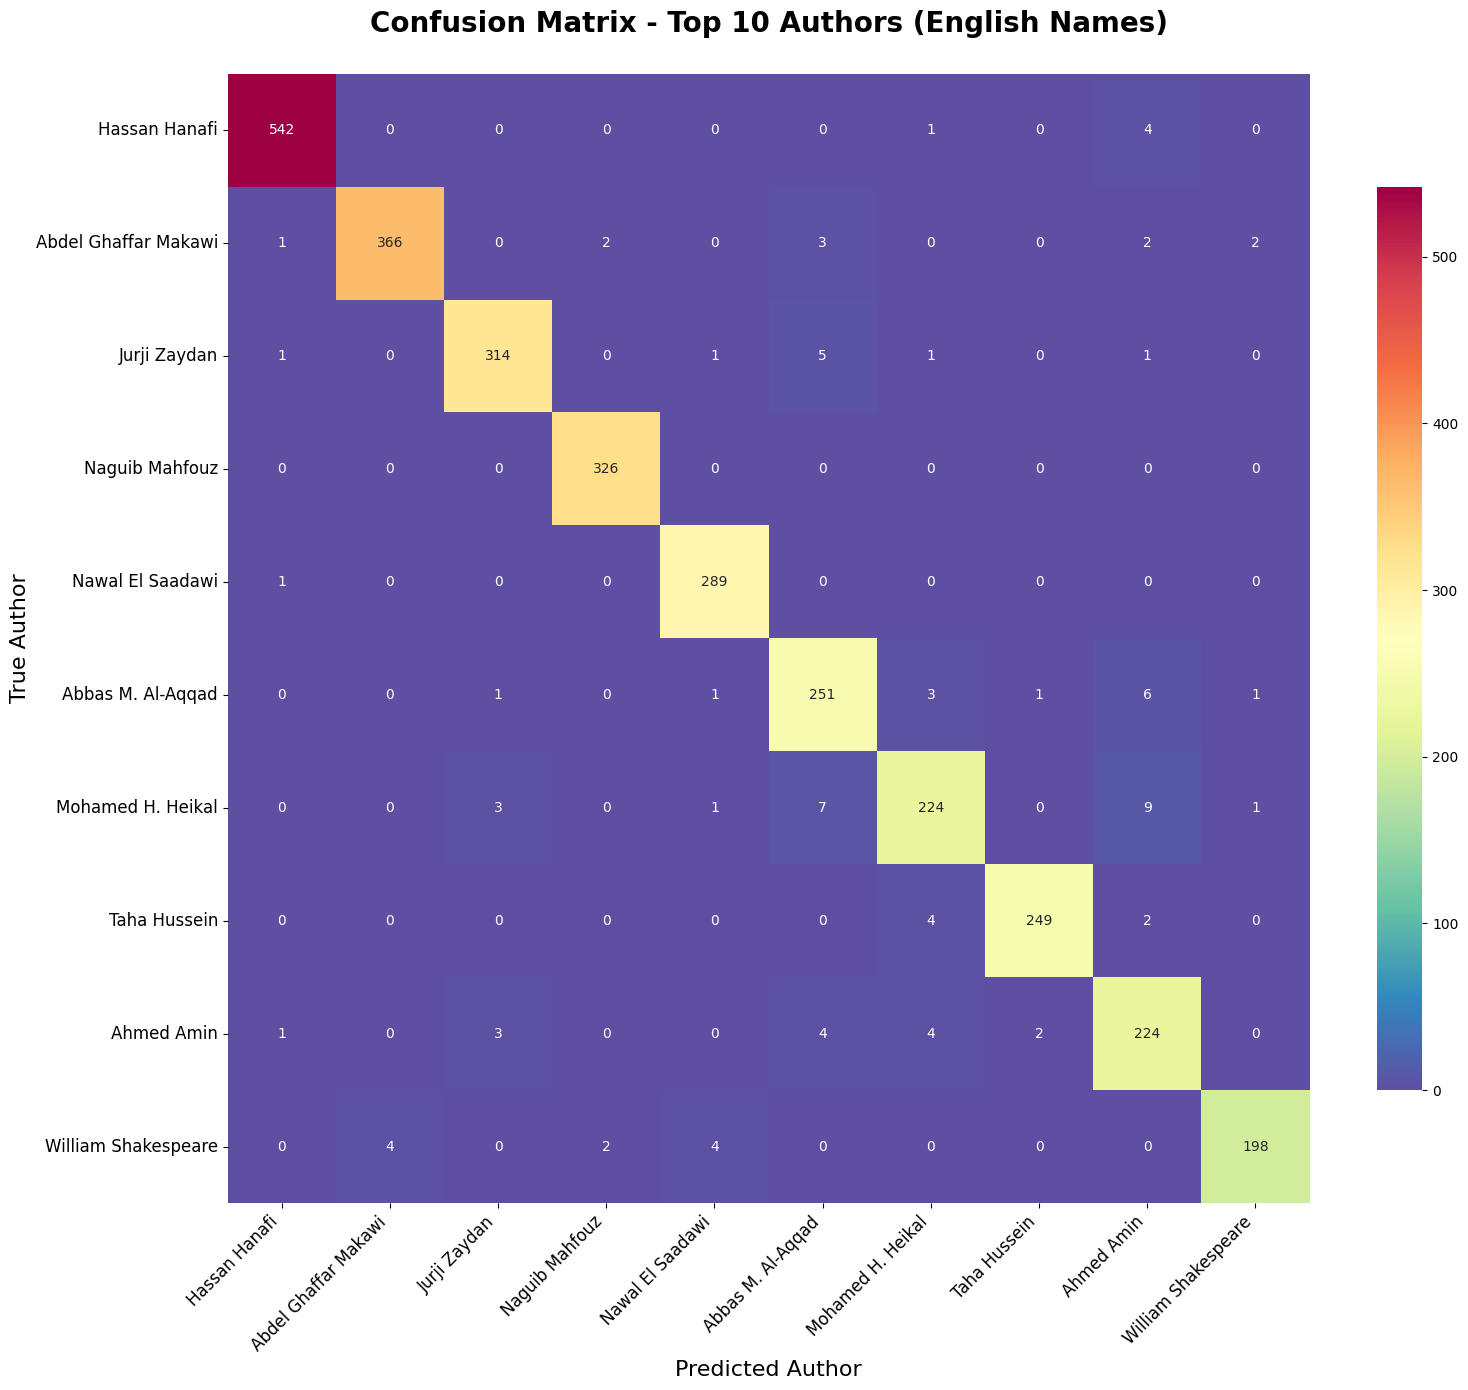

In [15]:
best_pred = predictions[best_model_name]
cm = confusion_matrix(y_val, best_pred)
authors_list = sorted(y_val.unique())

top_10_authors = val_filtered['author'].value_counts().head(10).index
top_10_authors_fixed = [fix_arabic_text(author) for author in top_10_authors]
val_top_10 = val_filtered[val_filtered['author'].isin(top_10_authors)]
y_val_top_10 = val_top_10['author']

indices_top_10 = val_filtered[val_filtered['author'].isin(top_10_authors)].index
original_indices = val_filtered.index.get_indexer(indices_top_10)
y_pred_top_10 = best_pred[original_indices]

cm_top_10 = confusion_matrix(y_val_top_10, y_pred_top_10, labels=top_10_authors)

plt.figure(figsize=(14, 12))
sns.heatmap(cm_top_10, annot=True, fmt='d', cmap='Spectral_r', 
            xticklabels=top_10_authors_fixed, yticklabels=top_10_authors_fixed,
            cbar_kws={'shrink': 0.8})
plt.title(f'Confusion Matrix - Top 10 Authors ({best_model_name})', 
          fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Predicted Author', fontsize=14)
plt.ylabel('True Author', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

create_confusion_matrix_english(y_val, best_pred, top_n=10)


# DETAILED ANALYSIS

In [16]:
print(f"\nBest Model: {best_model_name}")
print(f"Best F1-Score (Macro): {results[best_model_name]['f1_macro']:.4f}")

print(f"\nDetailed Classification Report ({best_model_name}):")
print(classification_report(y_val, best_pred))

author_performance = {}
for author in common_authors:
    author_mask = y_val == author
    if author_mask.sum() > 0:
        author_pred = best_pred[author_mask]
        author_true = y_val[author_mask]
        accuracy = accuracy_score(author_true, author_pred)
        author_performance[author] = {
            'accuracy': accuracy,
            'support': author_mask.sum()
        }

sorted_authors = sorted(author_performance.items(), key=lambda x: x[1]['accuracy'], reverse=True)

print(f"\nTop 10 Best Performing Authors:")
for author, metrics in sorted_authors[:10]:
    print(f"{author}: {metrics['accuracy']:.4f} (support: {metrics['support']})")

print(f"\nBottom 5 Performing Authors:")
for author, metrics in sorted_authors[-5:]:
    print(f"{author}: {metrics['accuracy']:.4f} (support: {metrics['support']})")



Best Model: Linear SVM (SGD)
Best F1-Score (Macro): 0.8752

Detailed Classification Report (Linear SVM (SGD)):
                   precision    recall  f1-score   support

        أحمد أمين       0.86      0.91      0.88       246
  أحمد تيمور باشا       0.87      0.79      0.83        57
        أحمد شوقي       0.56      0.83      0.67        58
    أمين الريحاني       0.91      0.97      0.94       142
       ثروت أباظة       0.91      0.44      0.60        90
 جبران خليل جبران       1.00      1.00      1.00        30
      جُرجي زيدان       0.95      0.96      0.96       327
         حسن حنفي       0.99      0.99      0.99       548
        روبرت بار       0.81      0.98      0.88        82
       سلامة موسى       0.95      1.00      0.98       119
          طه حسين       0.96      0.98      0.97       255
عباس محمود العقاد       0.92      0.94      0.93       267
 عبد الغفار مكاوي       0.99      0.92      0.96       396
     غوستاف لوبون       0.93      0.99      0.96       150
  

# SAVE MODELS AND GENERATE PREDICTIONS

In [ ]:
joblib.dump(best_model, 'best_authorship_model.pkl')
joblib.dump(tfidf_words, 'tfidf_words_vectorizer.pkl')
joblib.dump(tfidf_chars, 'tfidf_chars_vectorizer.pkl')

print("Models saved successfully!")

predictions_df = pd.DataFrame({
    'id': val_filtered['id'],
    'label': best_pred
})
predictions_df.to_csv('predictions.csv', index=False, encoding='utf-8-sig')

print(f"Validation predictions saved to 'predictions.csv'")
print(f"Number of predictions: {len(predictions_df)}")

# TEST DATA PROCESSING
print("\n10. Processing Test Data...")

try:
    test_data = pd.read_excel("Data/PublicDataFinalPhaseTask2.xlsx")
    print(f"Test data loaded: {len(test_data)} samples")
    
    test_data['cleaned_text'] = test_data['text_in_author_style'].apply(clean_arabic_text)
    test_data = test_data[test_data['cleaned_text'].str.len() > 10]
    
    # Extract features for test data
    X_test_words = tfidf_words.transform(test_data['cleaned_text'])
    X_test_chars = tfidf_chars.transform(test_data['cleaned_text'])
    X_test_combined = hstack([X_test_words, X_test_chars])
    
    # Generate predictions using best model
    test_predictions = best_model.predict(X_test_combined)
    
    # Save test predictions
    test_predictions_df = pd.DataFrame({
        'id': test_data['id'],
        'label': test_predictions
    })
    test_predictions_df.to_csv('test_predictions.csv', index=False, encoding='utf-8-sig')
    
    print(f"Test predictions saved to 'test_predictions.csv'")
    print(f"Number of test predictions: {len(test_predictions_df)}")
    
except Exception as e:
    print(f"Test data not found or error processing: {e}")


Models saved successfully!
Validation predictions saved to 'predictions.csv'
Number of predictions: 4157

10. Processing Test Data...
Test data loaded: 8413 samples
Test predictions saved to 'test_predictions.csv'
Number of test predictions: 8413


# FINAL SUMMARY

In [18]:
print("\n" + "=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)

print(f"\nDataset Information:")
print(f"- Training samples: {len(train_filtered)}")
print(f"- Validation samples: {len(val_filtered)}")
print(f"- Number of authors: {len(common_authors)}")
print(f"- Feature dimensions: {X_train_combined.shape[1]}")

print(f"\nModel Performance Ranking:")
sorted_results = sorted(results.items(), key=lambda x: x[1]['f1_macro'], reverse=True)
for i, (name, metrics) in enumerate(sorted_results, 1):
    print(f"{i}. {name}: F1-Macro = {metrics['f1_macro']:.4f}, Accuracy = {metrics['accuracy']:.4f}")

print(f"\nBest Model Configuration:")
print(f"- Model: {best_model_name}")
print(f"- Validation F1-Score (Macro): {results[best_model_name]['f1_macro']:.4f}")
print(f"- Validation Accuracy: {results[best_model_name]['accuracy']:.4f}")
if results[best_model_name]['cv_mean']:
    print(f"- Cross-Validation F1-Score: {results[best_model_name]['cv_mean']:.4f} ± {results[best_model_name]['cv_std']:.4f}")

print(f"\nFiles Generated:")
print(f"- best_authorship_model.pkl")
print(f"- tfidf_words_vectorizer.pkl")
print(f"- tfidf_chars_vectorizer.pkl")
print(f"- predictions.csv")
print(f"- test_predictions.csv (if test data available)")

print("\nAnalysis Complete! Ready for research paper.")
print("=" * 60)


FINAL RESULTS SUMMARY

Dataset Information:
- Training samples: 35122
- Validation samples: 4157
- Number of authors: 21
- Feature dimensions: 20000

Model Performance Ranking:
1. Linear SVM (SGD): F1-Macro = 0.8752, Accuracy = 0.9322
2. Logistic Regression: F1-Macro = 0.8246, Accuracy = 0.9040
3. Naive Bayes: F1-Macro = 0.6809, Accuracy = 0.7922
4. Random Forest: F1-Macro = 0.4628, Accuracy = 0.5932
5. Decision Tree: F1-Macro = 0.2435, Accuracy = 0.3223

Best Model Configuration:
- Model: Linear SVM (SGD)
- Validation F1-Score (Macro): 0.8752
- Validation Accuracy: 0.9322
- Cross-Validation F1-Score: 0.9767 ± 0.0010

Files Generated:
- best_authorship_model.pkl
- tfidf_words_vectorizer.pkl
- tfidf_chars_vectorizer.pkl
- predictions.csv
- test_predictions.csv (if test data available)

Analysis Complete! Ready for research paper.
